In [1]:
if "descended" not in locals():
    descended = 1
    %cd ".."
    
import utils

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import pickle

from simulations import lightcurve_simulation as lcsim
import visualize as vis
from detection import rnn_detection as rnndet
from detection import rnn_monodetection as mono
from dataloading import loading as dl
from tqdm import tqdm
import warnings

from wotan import flatten
from sklearn.metrics import mean_squared_error

/Users/Yke/Desktop/AI/Thesis/ESA/transit-detection-rnn


In [2]:
rnn_conf = torch.load("models/bigru1conf_w4sqrt_sim.pt")
rnn_ = torch.load("models/bigru1_w4sqrt_sim.pt")

## Illustration of application

In [3]:
np.random.seed(206)
# np.random.seed(0)
success = False
while not success:
    lc = lcsim.get_lightcurve(num_planets=1, min_transits=1, period_range=(2,100), t_max=27.4, 
                          max_attempts=4, max_snr_attempts=10, snr_range=(3,80), 
                          rdepth_range=(.5,5.), dur_range=(0,utils.hour2day(13)))
    time, flux, pl_masks, params = lc
    success = params["planets"][0]["pl_transits"] == 1
lctime = time.copy()
mask = pl_masks[0]

mean, std = -0.10192371859533564, 2.6337997430623323
flux_ = ((flux-1) / params["sigma"] - mean) / std

pts_conf, conf_conf = rnndet.get_pts(rnn_conf, flux_.reshape(1,-1), additional=True)
pts_ = rnndet.get_pts(rnn_, flux_.reshape(1,-1), additional=False)

standard_det_conf, conf_det_conf = mono.monotransit_detection(pts_conf, conf_conf, peak_thresh=0.5)
standard_det_, conf_det_ = mono.monotransit_detection(pts_, peak_thresh=0.5)

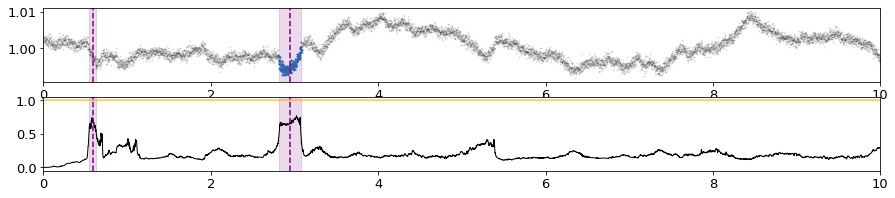

In [4]:
conf_model = 0
if conf_model:
    standard_det, conf_det = standard_det_conf, conf_det_conf
    pts, conf = pts_conf, conf_conf
else:
    standard_det, conf_det = standard_det_, conf_det_
    pts, conf = pts_, np.ones_like(pts_)

plt.figure(figsize=(15,3))
plt.subplot(2,1,1)
vis.plot(time[~mask], flux[~mask], c="black", a=0.1)
for msk in pl_masks:
    vis.plot(time[msk], flux[msk], c=plt.plot([])[0].get_color(), a=1)
for detection in standard_det:
    t0 = standard_det[detection]["t0"]
    dur = standard_det[detection]["duration"]
    plt.axvspan(t0-0.5*dur, t0+0.5*dur, color="purple", alpha=0.15)
    plt.axvline(t0, color="purple", alpha=1, linestyle="--")
# plt.xlim(0,time[-1])
plt.xlim(0,10)

plt.subplot(2,1,2)
vis.plot(time, pts, scatter=0)
vis.plot(time, conf, scatter=0, c="orange")
for detection in standard_det:
    t0 = standard_det[detection]["t0"]
    dur = standard_det[detection]["duration"]
    plt.axvspan(t0-0.5*dur, t0+0.5*dur, color="purple", alpha=0.15)
    plt.axvline(t0, color="purple", alpha=1, linestyle="--")
# plt.xlim(0,time[-1])
plt.xlim(0,10)
plt.show()

In [5]:
standard_det, conf_det

({0.68550605: {'t0': 0.5888888888888889, 'duration': 0.08194444444444438},
  0.7305853: {'t0': 2.95, 'duration': 0.25972222222222197}},
 {0.68550605: {'t0': 0.5888888888888889, 'duration': 0.08194444444444438},
  0.7305853: {'t0': 2.95, 'duration': 0.25972222222222197}})

## Detect transits and store results

In [6]:
rnn_conf = torch.load("models/bigru1conf_w4sqrt_sim.pt")
rnn_ = torch.load("models/bigru1_w4sqrt_sim.pt")

In [12]:
# mean, std = -0.10192371859533564, 2.6337997430623323  # obtained from training set
# fnames = [fnm for fnm in os.listdir("data/eval/sim/monotransit") if not fnm.startswith(".")]

# rnn_.to("cpu")
# rnn_conf.to("cpu")

# detections = {}
# pbar = tqdm(fnames)
# for fname in pbar:
#     try:
#         batch = dl.load_data("data/eval/sim/monotransit/"+fname)
#         if batch is None:
#             continue
#         sigma = np.array([batch["meta"][i]["sigma"] for i in batch["sampleid"]])
#         flux_ = ((batch["flux"]-1) / sigma[:,None] - mean) / std
  
#         flux_in = flux_.reshape(-1,flux_.shape[-1])
#         pts_ = np.zeros_like(flux_in)
#         pts_c, conf_c = np.zeros_like(flux_in), np.zeros_like(flux_in)

#         step = 50
#         for i in range(step, len(flux_in)+1, step):
#             pts_[i-step:i] = rnndet.get_pts(rnn_, flux_in[i-step:i], additional=False)
#             rnn_.to("cpu")
#             pts_c[i-step:i], conf_c[i-step:i] = rnndet.get_pts(rnn_conf, flux_in[i-step:i], additional=True)
#             rnn_conf.to("cpu")

#         for i, sampleid in enumerate(batch["sampleid"]):
#             standard_det_c, conf_det_c = mono.monotransit_detection(pts_c[i], conf_c[i], peak_thresh=0.5)
#             standard_det_, conf_det_ = mono.monotransit_detection(pts_[i], peak_thresh=0.5)
#             detections[sampleid] = {"std_det_c":standard_det_c,
#                               "conf_det_c":conf_det_c,
#                               "std_det_":standard_det_}
#     except:
#         pbar.close()
#         raise

## Results

In [7]:
def get_data_params(load_dir="data/eval/sim/monotransit"):
    meta = {}
    fnames = [fnm for fnm in os.listdir(load_dir) if not fnm.startswith(".")]
    for fname in fnames:
        batch = dl.load_data(load_dir + "/"+fname)
        if batch is None:
            continue
        meta = {**meta, **batch["meta"]}
    return meta

def get_results(load_pkl, best_only=False):
    with open(load_pkl, "rb") as f:
        detections = pickle.load(f)
    if best_only:
        for i in detections:
            for mname in detections[i]:
                if len(list(detections[i][mname].keys())):
                    mx = np.max(list(detections[i][mname].keys()))
                    detections[i][mname] = {mx:detections[i][mname][mx]}
    return detections

def correct_detection(params, detection):
    # assumes sample (params) contains single planet (&  single transit)
    if params["planets"] == {}:
        print("sample contains no planets")
        raise Exception
    t0_true = params["planets"][0]["pl_t0"]
    dur_true = params["planets"][0]["pl_duration"]
    correct = (detection["t0"] > (t0_true - 0.5*dur_true)) and (detection["t0"] < (t0_true + 0.5*dur_true))
    return correct

def evaluate_thresholds(detections, thresholds):
    snames = ["tp", "fp", "fn", "tn"]
    results = {mname:{sname:[] for sname in snames} for mname in detections[0]}
    pbar = tqdm(thresholds)
    for thr in pbar:  
        try:
            for mname in detections[0]:
                dic = results[mname]
                tp = fp = tn = fn = 0
                for i in meta:
                    contains_planet = len(meta[i]["planets"]) > 0
                    found_planet = False
                    for score, det in detections[i][mname].items():
                        if score >= thr:
                            if contains_planet and correct_detection(meta[i], det):
                                tp += 1
                                found_planet = True 
                            else:  # no planets in lc or false detection
                                fp += 1
                    if contains_planet and not found_planet:
                        fn += 1
                    # true negative is always inf
                results[mname]["tp"].append(tp), results[mname]["fp"].append(fp) 
                results[mname]["tn"].append(tn), results[mname]["fn"].append(fn) 
        except:
            pbar.close()
            raise
    for mname in detections[0]:
        for sname in snames:
            results[mname][sname] = np.array(results[mname][sname])
    return results

def get_fpr(dic):
    return dic["fp"] / (dic["fp"] + dic["tn"]) 
    
def get_tpr(dic):
    # recall
    return dic["tp"] / (dic["tp"] + dic["fn"])

def get_recall(dic):
    return get_tpr(dic)

def get_precision(dic):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        prec = dic["tp"] / (dic["tp"] + dic["fp"])
    prec[np.isnan(prec)] = 1
    return prec

def get_threshold(threshold_results, thresholds, precision_lvl=0.9):
    precision = get_precision(threshold_results)
    argmin = np.argmin(np.abs(precision-precision_lvl))
    thr = thresholds[argmin]
    return thr, precision[argmin]

In [45]:
meta = get_data_params()
bls_detections = get_results("results/bls_mono_detections.pkl")
rnn_detections = get_results("results/rnn_mono_detections.pkl")
# rnn_sde_detections = get_results("results/rnn_sde_single_detections.pkl")

In [46]:
scores = {mname:[] for mname in [*bls_detections[0], *rnn_detections[0]]}
for i in meta:
    for mname, dic in {**bls_detections[i], **rnn_detections[i]}.items():
        for score in dic:
            scores[mname].append(score)
for mname in scores:
    print(f"{mname}:  min = {round(min(scores[mname]),2)} | max = {round(max(scores[mname]),2)} | " +
          f"avg = {round(np.mean(scores[mname]),2)}")

bls_s2n:  min = 10.0 | max = 114.95 | avg = 15.34
bls_dfm:  min = 0.61 | max = 60.86 | avg = 3.39
bls_sde:  min = -0.41 | max = 12.5 | avg = 1.93
rnn:  min = 0.5 | max = 1.0 | avg = 0.68
rnnc:  min = 0.5 | max = 1.0 | avg = 0.69
rnnc_conf:  min = 0.5 | max = 1.0 | avg = 0.66


In [49]:
s2n_detections = {i:{"bls_s2n":bls_detections[i]["bls_s2n"]} for i in meta}
s2n_thresholds = np.linspace(10,115,100)
s2n_results = evaluate_thresholds(s2n_detections, s2n_thresholds)

100%|██████████| 100/100 [00:00<00:00, 103.41it/s]


In [50]:
dfm_detections = {i:{"bls_dfm":bls_detections[i]["bls_dfm"]} for i in meta}
dfm_thresholds = np.linspace(0.5,61,100)
dfm_results = evaluate_thresholds(dfm_detections, dfm_thresholds)

100%|██████████| 100/100 [00:01<00:00, 92.92it/s]


In [51]:
sde_detections = {i:{"bls_sde":bls_detections[i]["bls_sde"]} for i in meta}
sde_thresholds = np.linspace(-0.5,13,100)
sde_results = evaluate_thresholds(sde_detections, sde_thresholds)

100%|██████████| 100/100 [00:01<00:00, 71.23it/s]


In [53]:
bls_results = {**s2n_results, **dfm_results, **sde_results}

In [54]:
rnn_thresholds =  np.linspace(0,1,100)
rnn_results = evaluate_thresholds(rnn_detections, rnn_thresholds)

100%|██████████| 100/100 [00:03<00:00, 27.88it/s]


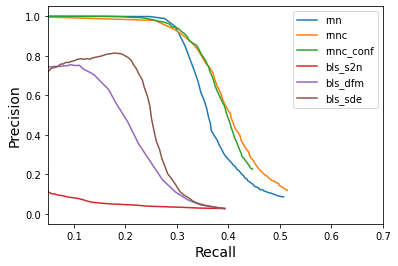

In [62]:
dontshow=[]
onlyshow=[]
combined_results = {**rnn_results, **bls_results}
for mname, dic in combined_results.items():
    if len(onlyshow)>0:
        if mname in onlyshow:
            plt.plot(get_recall(dic), get_precision(dic), label=mname)
#             plt.scatter(get_recall(dic), get_precision(dic), label=mname, s=2)
    elif mname not in dontshow:
        plt.plot(get_recall(dic), get_precision(dic), label=mname)
#         plt.scatter(get_recall(dic), get_precision(dic), label=mname, s=2)
plt.legend(), plt.xlim(0.05,0.7), plt.ylim(-0.05,1.05)
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.show()

#### BLS mono transit detection [TODO]

In [129]:
grid_frac = 0.33
durations = np.arange(1.,13.5,2)/24.
flat = flatten(lctime, flux, method="median", window_length=0.5)
d_s2n, d_dfm, d_sde = monotransit_detection(lctime, flat, params["sigma"], durations, grid_frac=grid_frac)

In [146]:
grid_frac = 0.33
durations = np.arange(1.,13.5,2)/24.
time_indc = None

write_path = "results/bls_monodetections"
utils.make_dir(write_path)

pbar = tqdm(os.listdir("data/eval/sim/monotransit"))
for fnm in pbar:
    try:
        if not fnm.startswith("."):

            with open("data/eval/sim/monotransit/"+fnm, "rb") as f:
                batch = pickle.load(f)
            batch_detections = {i:{} for i in batch["sampleid"]}

            for i, s_id in enumerate(batch["sampleid"]):
                flux = batch["flux"][i]
                lctime = np.arange(len(flux)) * utils.min2day(2)
                flat = flatten(lctime, flux, method="median", window_length=0.5)
                unc = batch["meta"][s_id]["sigma"]

                result = monotransit_detection(lctime, flat, unc, durations, 
                                               time_indc=time_indc, grid_frac=grid_frac, return_indc=1)
                d_s2n, d_dfm, d_sde, time_indc = result

                batch_detections[s_id]["s2n"] = d_s2n
                batch_detections[s_id]["dfm"] = d_dfm
                batch_detections[s_id]["sde"] = d_sde

            with open(write_path + "/" + fnm, "wb") as f:
                pickle.dump(batch_detections, f)
    except:
        pbar.close()
        raise

100%|██████████| 20/20 [2:21:33<00:00, 424.69s/it]  


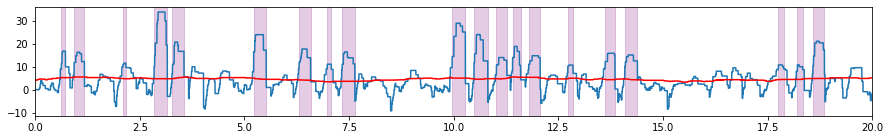

In [123]:
plt.figure(figsize=(15,2))
plt.plot(lctime, s2n), plt.plot(lctime, noise_, c="red"), plt.xlim(0,20)
for indc in tr_indc:
    from_, to_ = lctime[indc[0]], lctime[indc[-1]]
    
    plt.axvspan(from_, to_, alpha=0.2, color="purple")
plt.show()


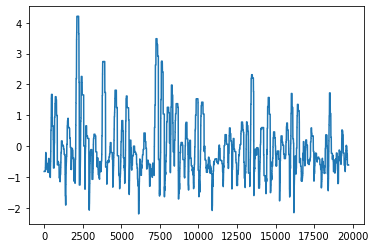

In [124]:
plt.plot(sde)

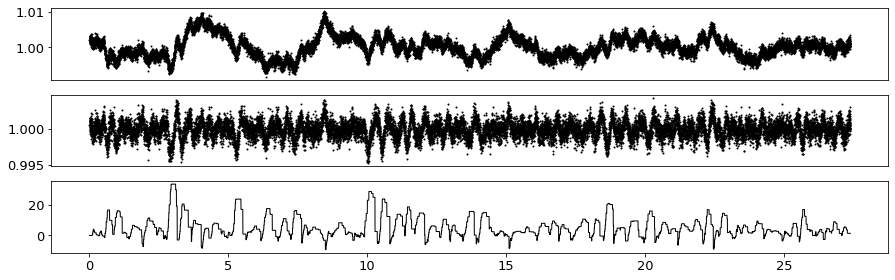

In [184]:
h = 3
plt.figure(figsize=(15,h*1.5))

plt.subplot(h,1,1), plt.xticks([])
vis.plot(lctime, flux)
# plt.xlim(0,10)

plt.subplot(h,1,2), plt.xticks([])
vis.plot(lctime, flat)
# plt.xlim(0,10)

plt.subplot(h,1,3)
vis.plot(lctime, s2nmax, scatter=0)
# plt.xlim(0,10)

/Users/Yke/Desktop/AI/Thesis/ESA/transit-detection-rnn/venv/lib/python3.6/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


ValueError: x and y must have same first dimension, but have shapes (19728,) and (7,)

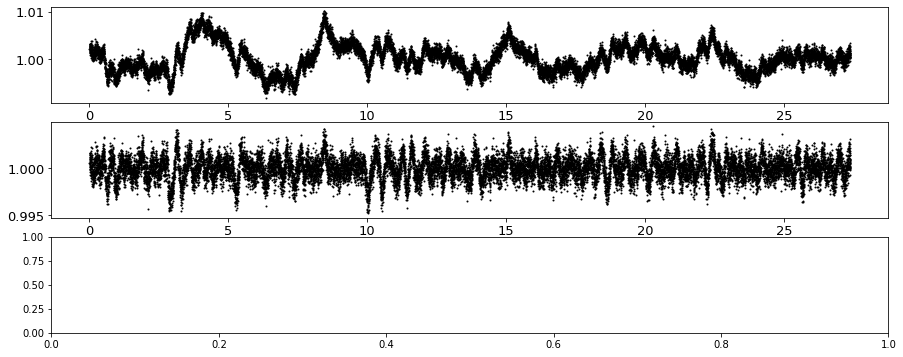

In [183]:
h = 3
plt.figure(figsize=(15,h*2))

plt.subplot(h,1,1)
vis.plot(lctime, flux)
# plt.xlim(0,10)


plt.subplot(h,1,2)
vis.plot(lctime, flat)
# plt.xlim(0,10)


plt.subplot(h,1,3)
vis.plot(lctime, s2n, scatter=0)
# plt.xlim(0,10)

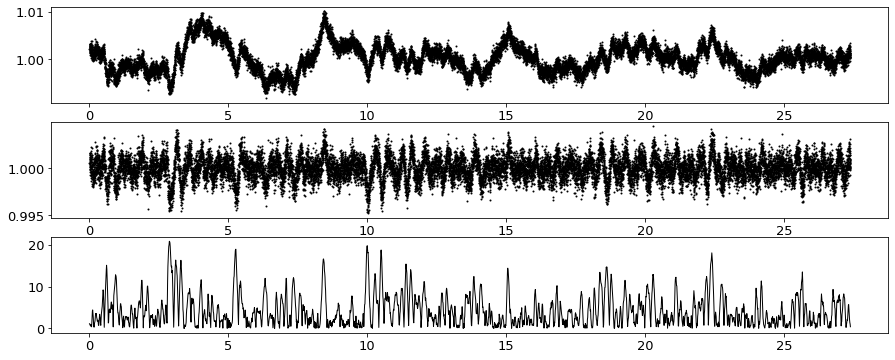

In [112]:
h = 3
plt.figure(figsize=(15,h*2))

plt.subplot(h,1,1)
vis.plot(lctime, flux)
# plt.xlim(0,10)


plt.subplot(h,1,2)
vis.plot(lctime, flat)
# plt.xlim(0,10)


plt.subplot(h,1,3)
vis.plot(time, np.abs(s2n), scatter=0)
# plt.xlim(0,10)